In [1]:
import MDAnalysis as mda
from MDAnalysis.lib.log import ProgressBar
import numpy as np
from mdcraft.analysis.profile import DensityProfile
from matplotlib import pyplot as plt
import pytim
import os
import glob
import pandas as pd
from tqdm import tqdm
import copy
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


rcParams = plt.matplotlib.rcParams

WIDTH = 1.5 * 8.3 / 2.54
DOUBLE_WIDTH = 1.5 * 17.1 / 2.54
DPI = 150
rcParams['axes.labelsize']= 14
rcParams['axes.xmargin']= 0
rcParams['axes.ymargin']= .1
rcParams['lines.markersize']= 5
rcParams['figure.dpi']= DPI
rcParams['figure.autolayout']= True
rcParams['figure.figsize']= (WIDTH, 3 * WIDTH / 4)
rcParams['figure.facecolor']= 'white'
rcParams['font.size']= 12
rcParams['grid.color']= '0'
rcParams['grid.linestyle']= '-'
rcParams['legend.edgecolor']= '1'
rcParams['legend.fontsize']= 10
rcParams['xtick.labelsize']= 12
rcParams['ytick.labelsize']= 12
rcParams['xtick.direction']= 'in'
rcParams['ytick.direction']= 'in'
rcParams['font.family']= 'serif'
rcParams['font.sans-serif']= ['Helvetica']
rcParams['text.usetex']=True
# Create color wheel
rcParams['axes.prop_cycle'] = plt.matplotlib.cycler(color=['#4063D8','#009B72','#FFB400','#D80032','#9558B2','#808080'])

pw_cmap = LinearSegmentedColormap.from_list('pw_cmap', ['#4063D8','#FFFFFF','#FFB400'])

/home/pjwalker/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Trajectory

Text(0, 0.5, '$\\langle r_i \\rangle$')

<Figure size 735.236x551.427 with 0 Axes>

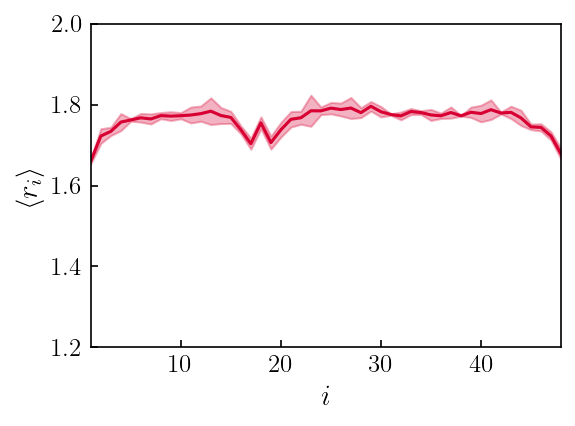

In [8]:
# have projection look at the interface
files = ['poly_sequ_POINT_nchain_1_znet_48_nsalt_0_temp_1']
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)

for (i, f) in enumerate(files):
    r13 = np.load('../data/'+f+'/r13_blocks.npy')
    err = r13.max(axis=1)-r13.min(axis=1)
    ax.plot(np.arange(1,r13.shape[0]+1), r13.mean(axis=1)+i, color=f'C3')
    ax.fill_between(np.arange(1,r13.shape[0]+1), r13.mean(axis=1)-err/2+i, r13.mean(axis=1)+err/2+i, alpha=0.3, color=f'C3')
ax.set_ylim(1.2,2.0)
# ax.text(-0.05,0.5,r'$\langle r_i \rangle$',rotation=90,va="center",ha="right",transform=ax.transAxes)
# ax.set_yticklabels([])
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\langle r_i \rangle$")

In [2]:
tag = f'poly_sequ_0.0ALPHA_nchain_1_znet_0_nsalt_0_temp_1'
u = mda.Universe('../data/'+tag+'/input.data', '../data/'+tag+'/drop.lammpstrj',format='LAMMPSDUMP', atom_style='id mol type q x y z', extras=[])
print(len(u.trajectory))

31001


/home/pjwalker/.local/lib/python3.10/site-packages/mdcraft/analysis/reader.py:360: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = ts.data["step"] * ts.dt


In [3]:
idx_start = 1000
n_blocks = 4
rij = np.zeros((50,50,n_blocks))
block_size = (u.trajectory.n_frames - idx_start)//n_blocks

for b in range(n_blocks):
    for ts in tqdm(u.trajectory[idx_start + b*block_size : idx_start + (b+1)*block_size]):
        ri = u.residues[0].atoms.positions[0:50,:]
        rj = copy.deepcopy(ri)
        _rij = ri[:,np.newaxis,:] - rj[np.newaxis,:,:]
        # Apply minimum image convention
        _rij[_rij > u.dimensions[0]/2] -= u.dimensions[0]
        _rij[_rij < -u.dimensions[0]/2] += u.dimensions[0]
        rij[:,:,b] += np.linalg.norm(_rij, axis=-1)
    rij[:,:,b] /= block_size*0.97
# np.save(f'../data/{tag}/rij_blocks.npy', rij)

100%|██████████| 7500/7500 [00:05<00:00, 1485.30it/s]


In [4]:
Rij = np.zeros(49)
for i in range(49):
    for j in range(50 - i):
        Rij[i] += np.mean(rij[j,j+i,:])
    Rij[i] /= (50 - i)

<Figure size 735.236x551.427 with 0 Axes>

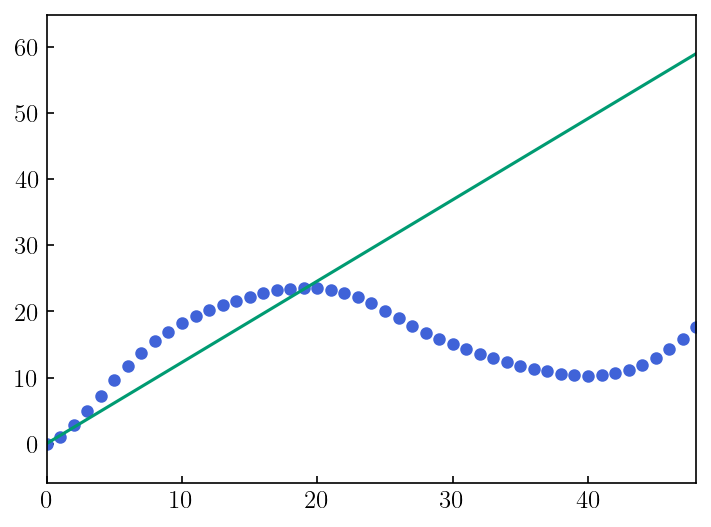

In [10]:
plt.clf()
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,49), Rij**2, marker='o', linestyle='none')
ax.plot(np.arange(0,49), 1.23*np.arange(0,49), label=r'$R_{ij} \sim |i-j|^{0.5}$')

<Figure size 735.236x551.427 with 0 Axes>

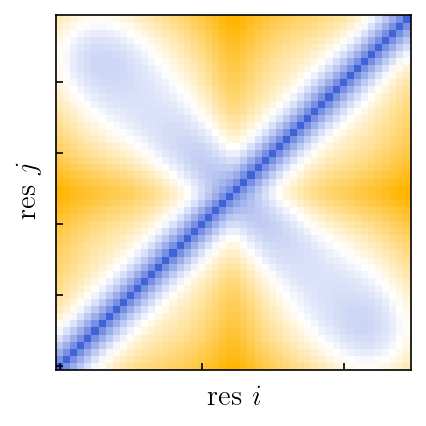

In [53]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
ax.pcolor(rij[:,:,0].T, cmap=pw_cmap, shading='nearest')
ax.set_xlabel(r'res $i$')
ax.set_ylabel(r'res $j$')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('matrix_rij.svg', transparent=True)

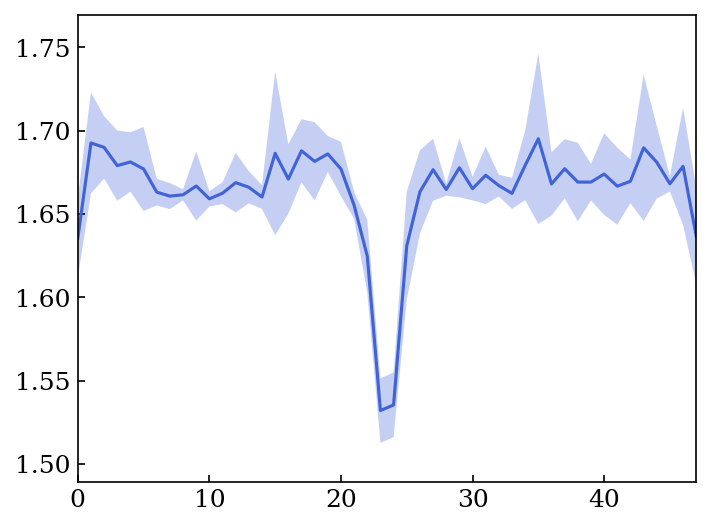

In [34]:
plt.clf()
plt.plot(range(0,48), r13.mean(axis=1),'-')
err = (r13.max(axis=1) - r13.min(axis=1))/2
plt.fill_between(range(0,48), r13.mean(axis=1) - err, r13.mean(axis=1) + err, alpha=0.3)

/home/pjwalker/.local/lib/python3.10/site-packages/mdcraft/analysis/reader.py:360: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = ts.data["step"] * ts.dt
/home/pjwalker/.local/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:177: DeprecationWarning: `guess_atom_element` is deprecated!
`guess_atom_element` will be removed in release 3.0.0.
MDAnalysis.topology.guessers is deprecated in favour of the new Guessers API. See MDAnalysis.guesser.default_guesser for more details.
  return np.array([guess_atom_element(name) for name in atom_names], dtype=object)
100%|██████████| 1089/1089 [02:43<00:00,  6.66it/s]


KeyboardInterrupt: 

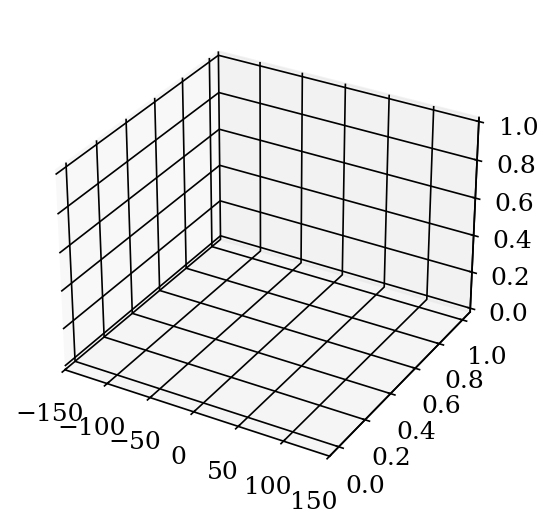

In [126]:

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-150,150)

radii_dict = {'1': 1,
              '2': 1}

seqs = [0.0, 0.2, 0.4]
chrgs = [0,2]

rhoL = np.zeros((len(seqs),len(chrgs)))
rhoV = np.zeros((len(seqs),len(chrgs)))

u_rhoL = np.zeros((len(seqs),len(chrgs)))
u_rhoV = np.zeros((len(seqs),len(chrgs)))

_rhoL = np.zeros((len(seqs),len(chrgs),3000))
_rhoV = np.zeros((len(seqs),len(chrgs),3000))

for j,seq in enumerate(seqs):
    for k, chrg in enumerate(chrgs):

        tag = f'poly_sequ_{seq}ALPHA_nchain_400_znet_{chrg}_nsalt_0_temp_1_bulk'

        u = mda.Universe('../data/'+tag+'/input.data', '../data/'+tag+'/drop.lammpstrj',format='LAMMPSDUMP', atom_style='id mol type q x y z', extras=[])
        interface = pytim.ITIM(u, molecular=False, normal='x', radii_dict=radii_dict)

        # _rhoL = np.zeros(len(u.trajectory)-1001)
        # _rhoV = np.zeros(len(u.trajectory)-1001)
        for i,ts in enumerate(ProgressBar(u.trajectory[1001:])):
            int1 = interface.layers[0,0].positions
            int2 = interface.layers[-1,0].positions

            interface1_x = np.mean(int1[:, 0])
            interface2_x = np.mean(int2[:, 0])
            # Find the number of particles between the two interfaces
            nL = np.sum((ts.positions[:,0] < interface1_x) & (ts.positions[:,0] > interface2_x))
            V = np.abs(interface1_x - interface2_x) * u.dimensions[1] * u.dimensions[2]
            _rhoL[j,k,i] = nL / V

            nV =  np.sum((ts.positions[:,0] > interface1_x) | (ts.positions[:,0] < interface2_x))
            V = u.dimensions[0] * u.dimensions[1] * u.dimensions[2] - V
            _rhoV[j,k,i] = nV / V
        idx = np.where(_rhoL[j,k,:] == 0)[0][0]
        rhoL[j,k] = np.mean(_rhoL[j,k,idx-500:idx])
        u_rhoL[j,k] = np.std(_rhoL[j,k,idx-500:idx])
        rhoV[j,k] = np.mean(_rhoV[j,k,idx-500:idx])
        u_rhoV[j,k] = np.std(_rhoV[j,k,idx-500:idx])


/home/pjwalker/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pjwalker/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pjwalker/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pjwalker/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/pjwalker/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 1.0)

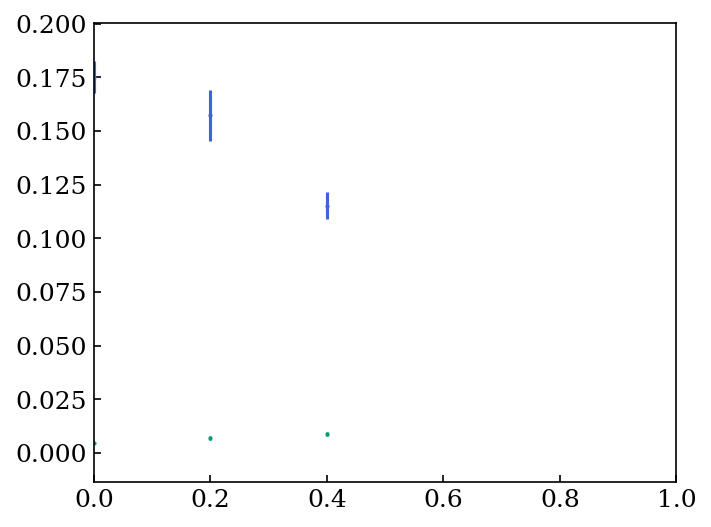

In [ ]:
alpha = [0.0, 0.2, 0.4, 0.6, 0.8]

u_rhoL = np.zeros(len(seqs))
u_rhoV = np.zeros(len(seqs))
for i in range(len(seqs)):
    # use 500 frames from the start of the first zero
    

plt.errorbar(alpha,rhoL, yerr=u_rhoL, label='Liquid', fmt='o', markersize=1)
plt.errorbar(alpha,rhoV, yerr=u_rhoV, label='Vapor', fmt='o', markersize=1)
plt.xlim(0,1)


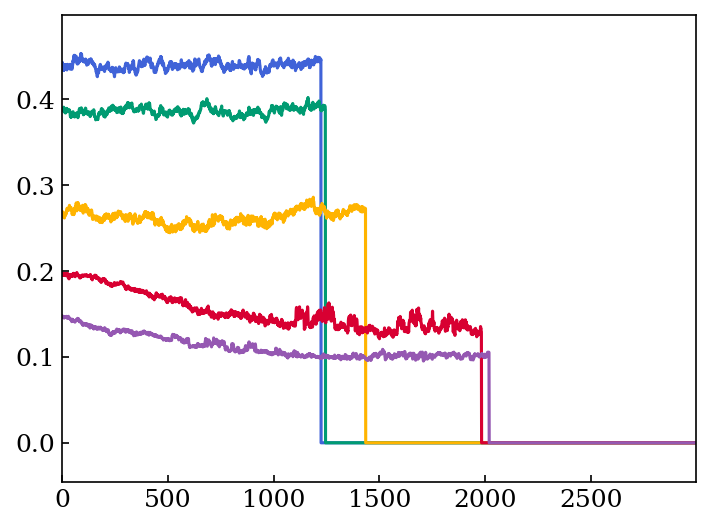

In [121]:
plt.plot(_rhoL.transpose())

poly_sequ_0.0ALPHA_nchain_400_znet_2_nsalt_0_temp_1_bulk


/home/pjwalker/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
/home/pjwalker/.local/lib/python3.10/site-packages/mdcraft/analysis/profile.py:819: UserWarning: Not all atoms in `groups[0]` share the same charge. The charge density profile will not be calculated.
  warnings.warn(wmsg)
100%|██████████| 1616/1616 [00:39<00:00, 41.26it/s]


poly_sequ_0.2ALPHA_nchain_400_znet_2_nsalt_0_temp_1_bulk


100%|██████████| 1019/1019 [00:24<00:00, 41.39it/s]


poly_sequ_0.4ALPHA_nchain_400_znet_2_nsalt_0_temp_1_bulk


100%|██████████| 1069/1069 [00:25<00:00, 41.46it/s]


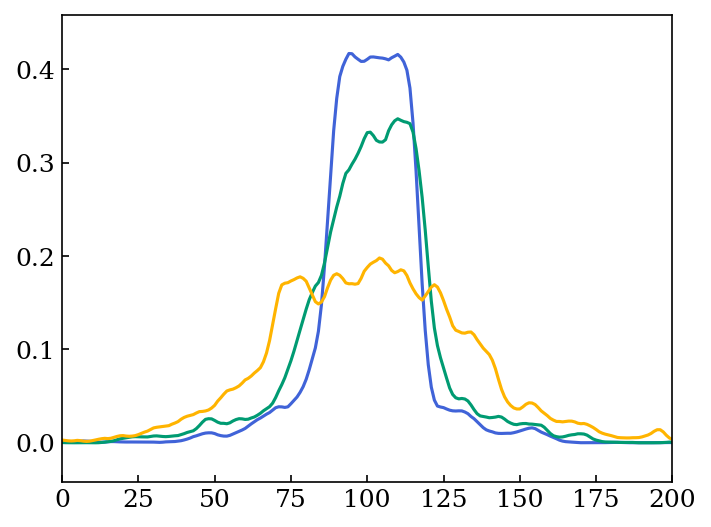

In [2]:
seqs = ['0.0ALPHA','0.2ALPHA', '0.4ALPHA']

rho_coacervate = np.empty((len(seqs), 2))
rho_supernatant = np.empty((len(seqs), 2))

rho_coacervate = np.empty(len(seqs))
rho_supernatant = np.empty(len(seqs))
plt.clf()
for i, seq in enumerate(seqs):
    tag = f'poly_sequ_{seq}_nchain_400_znet_2_nsalt_0_temp_1_bulk'
    print(tag)

    # Create the DensityProfile object
    # if os.path.isfile('../data/'+tag+'/dens_prof.npz'):
    #     number_densities = np.load('../data/'+tag+'/dens_prof.npz', allow_pickle=True)['arr_0'][0]
    #     pass
    # else:
    u = mda.Universe('../data/'+tag+'/input.data', '../data/'+tag+'/drop.lammpstrj',format='LAMMPSDUMP')
    ag = u.select_atoms('type 1 or type 2 or type 3')

    # Define the direction for the density profile
    str_direction = 'x'

    density_profile = DensityProfile(groups=ag, groupings='atoms', axes=str_direction, n_bins=201, reduced = True, verbose=True)

    # Compute the density profile
    density_profile.run(start=1001, step=1)
    np.savez('../data/'+tag+'/dens_prof',density_profile.results.number_densities['x'])
    number_densities = density_profile.results.number_densities['x'][0]
    plt.plot(number_densities)

    tol = 5e-3
    

    bulk = np.abs(np.gradient(number_densities, edge_order=2)) <= tol
    indices_cutoff = np.where(np.diff(bulk))[0] + 1
    split_bool_equal = np.split(bulk, indices_cutoff)
    split_indices = np.split(np.arange(number_densities.shape[0]), indices_cutoff)
    # print(split_indices)
    rho_supernatant[i] = number_densities[np.r_[split_indices[0],split_indices[4]]].mean()
    rho_coacervate[i] = number_densities[split_indices[2]].mean()

# Retrieve the density data

In [3]:
rho_coacervate

array([0.4557853 , 0.40195875, 0.29500063, 0.20770475, 1.        ])

In [4]:
rho_coacervate


array([0.4557853 , 0.40195875, 0.29500063, 0.20770475, 1.        ])

(0.0, 0.5)

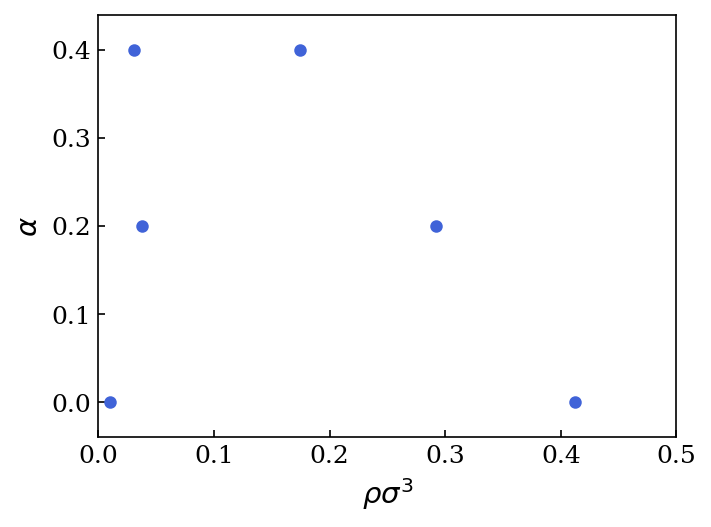

In [4]:
chi = [0.0,0.2,0.4]
plt.clf()
plt.plot(rho_coacervate,chi,'o',color="C0")
plt.plot(rho_supernatant,chi,'o',color="C0")
plt.xlabel(r'$\rho\sigma^3$')
plt.ylabel(r'$\alpha$')
plt.xlim(0,0.5)
#at 0.4 and above, can't phase split anymore so not worth running anymore


poly_sequ_0.0ALPHA_nchain_400_znet_0_nsalt_0_temp_1_bulk


/home/pjwalker/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
/home/pjwalker/.local/lib/python3.10/site-packages/mdcraft/analysis/profile.py:819: UserWarning: Not all atoms in `groups[0]` share the same charge. The charge density profile will not be calculated.
  warnings.warn(wmsg)
100%|██████████| 1725/1725 [00:37<00:00, 45.96it/s]


poly_sequ_0.0ALPHA_nchain_400_znet_2_nsalt_0_temp_1_bulk


100%|██████████| 2116/2116 [00:47<00:00, 44.14it/s]


poly_sequ_0.0ALPHA_nchain_400_znet_4_nsalt_0_temp_1_bulk


100%|██████████| 769/769 [00:17<00:00, 43.23it/s]


poly_sequ_0.0ALPHA_nchain_400_znet_6_nsalt_0_temp_1_bulk


100%|██████████| 1679/1679 [00:40<00:00, 41.65it/s]


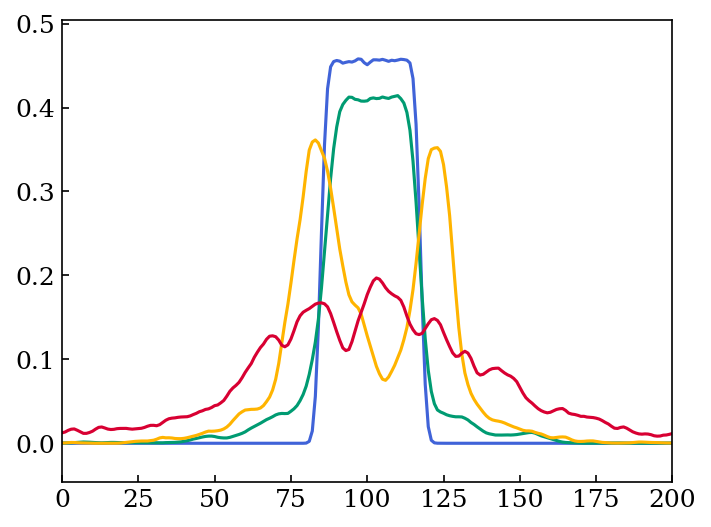

In [3]:
charge = ['0','2','4','6']

rho_coacervate = np.empty((len(charge), 2))
rho_supernatant = np.empty((len(charge), 2))

rho_coacervate = np.empty(len(charge))
rho_supernatant = np.empty(len(charge))
plt.clf()
for i, chrg in enumerate(charge):
    tag = f'poly_sequ_0.0ALPHA_nchain_400_znet_{chrg}_nsalt_0_temp_1_bulk'
    print(tag)

    # Create the DensityProfile object
    # if os.path.isfile('../data/'+tag+'/dens_prof.npz'):
    #     number_densities = np.load('../data/'+tag+'/dens_prof.npz', allow_pickle=True)['arr_0'][0]
    #     pass
    # else:
    u = mda.Universe('../data/'+tag+'/input.data', '../data/'+tag+'/drop.lammpstrj',format='LAMMPSDUMP')
    ag = u.select_atoms('type 1 or type 2 or type 3')

    # Define the direction for the density profile
    str_direction = 'x'

    density_profile = DensityProfile(groups=ag, groupings='atoms', axes=str_direction, n_bins=201, reduced = True, verbose=True)

    # Compute the density profile
    density_profile.run(start=501, step=1)
    np.savez('../data/'+tag+'/dens_prof',density_profile.results.number_densities['x'])
    number_densities = density_profile.results.number_densities['x'][0]
    plt.plot(number_densities)

    tol = 5e-3
    

    bulk = np.abs(np.gradient(number_densities, edge_order=2)) <= tol
    indices_cutoff = np.where(np.diff(bulk))[0] + 1
    split_bool_equal = np.split(bulk, indices_cutoff)
    split_indices = np.split(np.arange(number_densities.shape[0]), indices_cutoff)
    # print(split_indices)
    rho_supernatant[i] = number_densities[np.r_[split_indices[0],split_indices[4]]].mean()
    rho_coacervate[i] = number_densities[split_indices[2]].mean()

# Retrieve the density data

(0.0, 0.5)

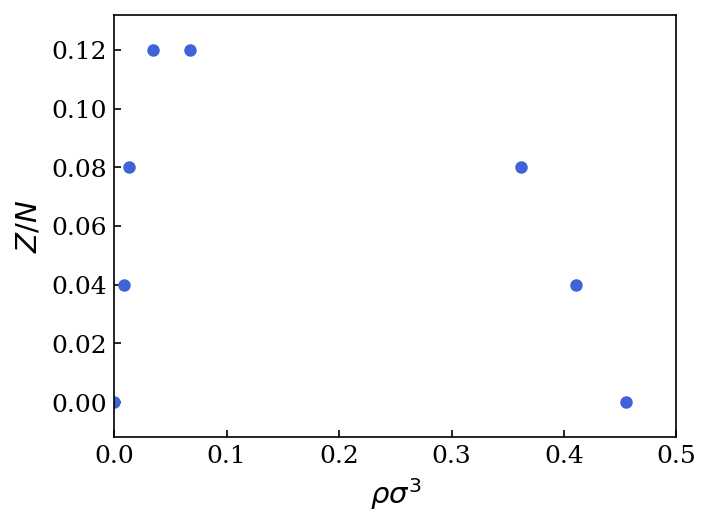

In [4]:
Z = np.array([0,2,4,6])/50
plt.clf()
plt.plot(rho_coacervate,Z,'o',color="C0")
plt.plot(rho_supernatant,Z,'o',color="C0")
plt.xlabel(r'$\rho\sigma^3$')
plt.ylabel(r'$Z/N$')
plt.xlim(0,0.5)
#at 0.4 and above, can't phase split anymore so not worth running anymore


In [14]:
tol = 1e-3

bulk = np.abs(np.gradient(number_densities, edge_order=2)) <= tol
indices_cutoff = np.where(np.diff(bulk))[0] + 1
split_bool_equal = np.split(bulk, indices_cutoff)
split_indices = np.split(np.arange(number_densities.shape[0]), indices_cutoff)

supernatant = number_densities[np.r_[split_indices[0],split_indices[4]]].mean()
coacervate = number_densities[split_indices[2]].mean()

In [28]:
coacervate

0.230946931024531

In [29]:
supernatant

0.024348070707070707

# Density Profile

In [37]:
# Find second line with Pxx in the file
alpha = [0.0,0.2,0.4,0.6]
gamma = np.zeros(len(alpha))
u_gamma = np.zeros(len(alpha))
for a in alpha:
    tag = f'poly_sequ_{a}ALPHA_nchain_400_znet_0_nsalt_0_temp_1_bulk/'
    path = '../data/'+tag
    idx = 0
    with open(path+'log.lammps') as f:
        for line in f:
            idx += 1
            if 'Pxx' in line:
                break
        for line in f:
            idx += 1
            if 'Pxx' in line:
                break
        for line in f:
            if 'Pxx' in line:
                break
            idx += 1

    # Read file from line idx to the end and store it in a list
    data = np.loadtxt(path+'log.lammps', skiprows=idx+1)
    gamma[alpha.index(a)] = (np.mean(data[:,3]) - (np.mean(data[:,4])+np.mean(data[:,5]))/2)*300/2
    u_gamma[alpha.index(a)] = np.sqrt(np.std(data[:,3])**2+np.std(data[:,4])**2/4+np.std(data[:,5])**2/4)*300/2

<ErrorbarContainer object of 3 artists>

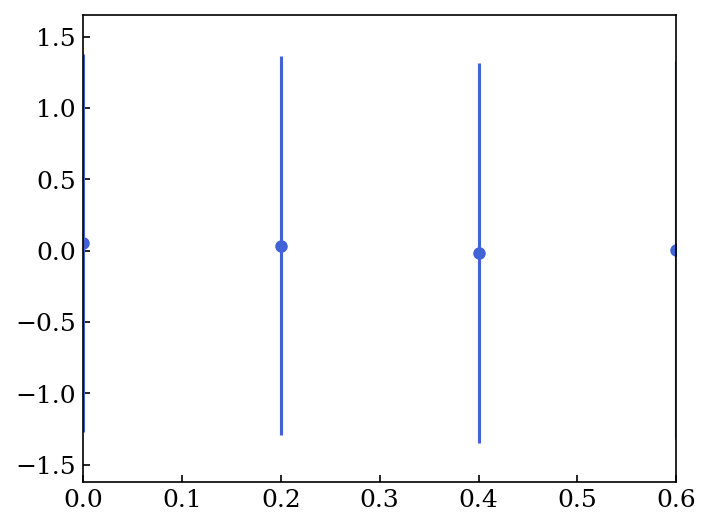

In [38]:
plt.clf()
plt.errorbar(alpha,gamma,yerr=u_gamma,fmt='o')

In [ ]:
gyr = Gyradius(ag,n_chains=1,n_monomers=40, unwrap=True)

In [10]:
gyr.run(start=1000)

100%|██████████| 10001/10001 [00:07<00:00, 1401.00it/s]


In [11]:
np.savetxt('../data/'+tag+'/gyr.txt',gyr.results.gyradii)

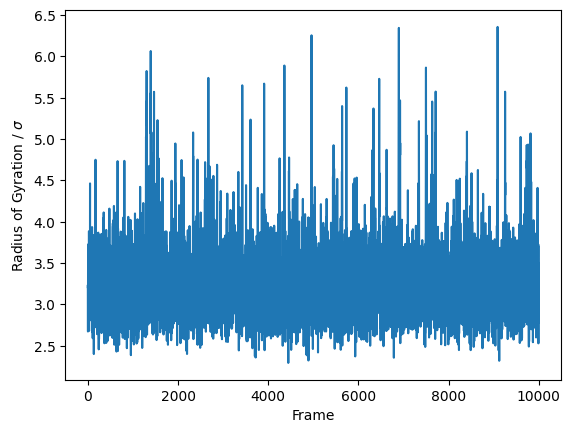

In [12]:
plt.plot(gyr.results.gyradii[0])
plt.xlabel('Frame')
plt.ylabel(f'Radius of Gyration / $\sigma$')
# plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/gyr.pdf')

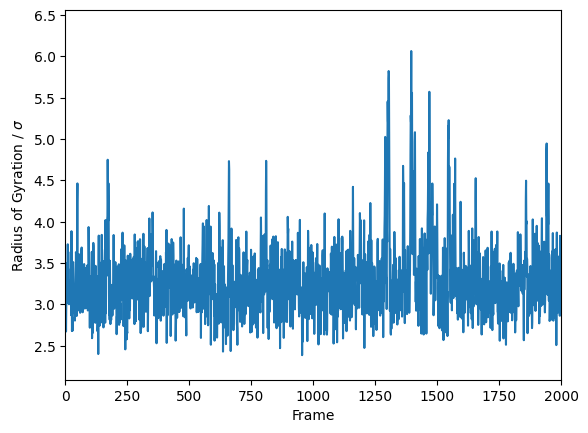

In [13]:
plt.plot(gyr.results.gyradii[0])
plt.xlabel('Frame')
plt.ylabel(f'Radius of Gyration / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/gyr.pdf')

# End-to-end Vector

In [ ]:
e2e = EndToEndVector(ag,n_chains=1,n_monomers=40, unwrap=True)

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [ ]:
e2e.run(start=1000)
e2e.save('../data/'+tag+'/e2e')

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
100%|██████████| 10001/10001 [00:01<00:00, 6703.39it/s]
1it [00:00, 684.45it/s]


In [ ]:
abs_e2e = np.zeros(len(e2e._e2e))

for i in range(len(e2e._e2e)):
    abs_e2e[i] = np.linalg.norm(e2e._e2e[i])

abs_e2e

array([11.37302373, 12.22581104, 11.74046475, ..., 10.44642166,
       11.09361762,  8.23964467])

In [ ]:
plt.plot(e2e.results.times,abs_e2e)
plt.xlabel('Frame')
plt.ylabel('End-to-End Distance / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/e2e.pdf')

AttributeError: 'Results' object has no attribute 'times'

In [ ]:
plt.semilogx(e2e.results.times,e2e.results.acf[0][0])
plt.xlabel('Frame')
plt.ylabel(r'$ \rho_{e2e}(t)$')   
plt.xlim(0,3000)

AttributeError: 'Results' object has no attribute 'times'